# Natural Language Processing with Disaster Tweets

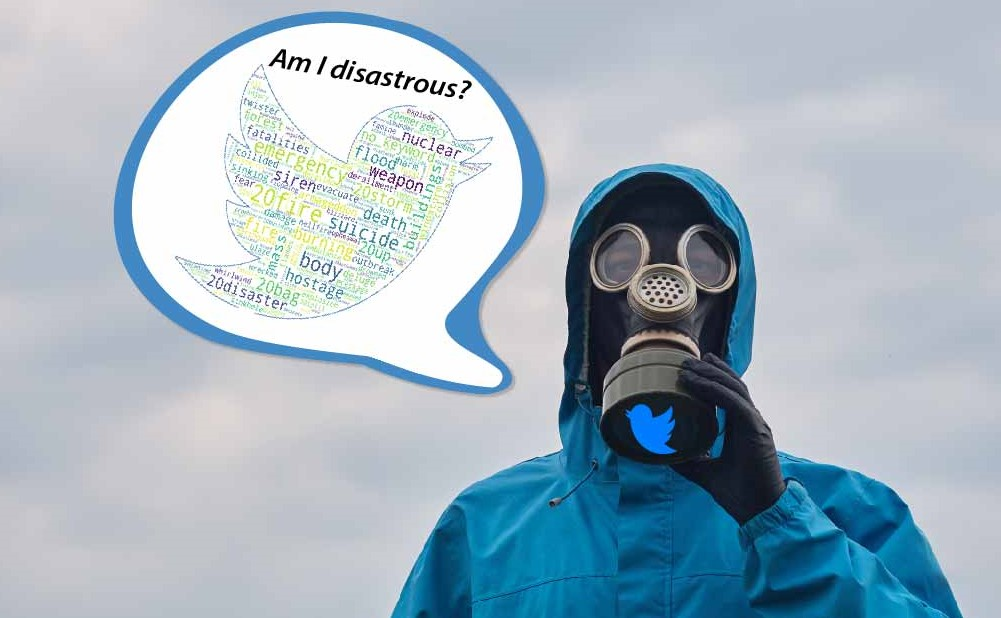

In [ ]:
import re                                                 # Regular Expression
import spacy                                              # spaCy for Lemmatization
import string                                             # Used for its string properties
import numpy as np                                        # Numpy for Linear Algebra
import pandas as pd                                       # Pandas for DataFrames
from matplotlib import pyplot as plt                      # Matplotlib for plots
%matplotlib inline
plt.style.use('ggplot')

from wordcloud import WordCloud                           # Wordclouds
from tqdm import tqdm                                     # Interactive enumerator
from sklearn.model_selection import train_test_split

# Keras
from keras.preprocessing.text import Tokenizer            # Tokenizer
from keras.preprocessing.sequence import pad_sequences    # Sequence Padder
from keras.models import Sequential                       # Sequential model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D,
                          SpatialDropout1D)               # Layers

# tensorflow
import tensorflow as tf

# transformers
from transformers import TFBertModel, BertModel
from transformers import BertTokenizer

nlp = spacy.load('en_core_web_sm')  # Load the English language (Other options: en_core_web_md, en_core_web_lg)

## 1.Load Data

In [ ]:
# Load data
train_df = pd.read_csv('../input/nlp-getting-started/train.csv')
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')

# Combine data for easier iteration
combined = [train_df, test_df]

# Shuffle
for df in combined:    
    df = df.sample(frac = 1).reset_index(drop = True)

# Print basic properties
print(f"Training Data has {train_df.shape[0]} rows and {train_df.shape[1]} columns: ({list(train_df.columns)})")
print(f"Testing Data has {test_df.shape[0]} rows and {test_df.shape[1]} columns: ({list(test_df.columns)})")

## 2.Exploratory Data Analysis (EDA)

### 2.1.Target feature

In [ ]:
# Correct a few errors in the training data
# https://www.kaggle.com/wrrosa/keras-bert-using-tfhub-modified-train-data

target_error_ids = [328, 443, 513, 2619, 3640, 3900, 4342, 5781, 6552, 6554, 6570, 6701, 6702, 6729, 6861, 7226]
train_df.loc[train_df['id'].isin(target_error_ids), 'target'] = 0

In [ ]:
train_df.groupby(by = 'target', as_index = False)['target'].count()

Looking at the distribution, I say it's OK. It's not evenly balanced and that can be something we might want to fix by downcasting the data later when optimizing the model. Downcasting may or may not be a good idea as we loose some of our data! (You have to test it to find out its impact on the model)

### 2.2.Keyword feature

#### Analysis

In [ ]:
# NULL entries
null_entries = train_df.loc[train_df['keyword'].isnull()]
null_entries_count = len(null_entries)
print(f'- There are {null_entries_count} missing entries on "keyword" column ({round(null_entries_count / train_df.shape[0] * 100, 2)}%)')

# Uniqueness
unique_locations = train_df['keyword'].unique()
unique_locations_count = len(unique_locations)
print(f'- Number of unique keyword: {unique_locations_count} ({round(unique_locations_count/train_df.shape[0]*100, 2)}%)')

By analyzing the results and taking a quick look at the data itself, I found:
- There are only 8 missing entries (less than 1%) which we can take care of by imputing them.
- Only 222 unique keywords exist (~3%) which might be too good or too bad for us, We'll see..
- Looking at the 25 most frequently used keywords, they are mostly about disasters (more than 80% of top 25 keywords)
- Keywords must be lemmatized. (For instance we have both *sinking* and *sunk*)

#### Feature Engineering

In [ ]:
# Lemmatize text
def lemmatize_text(text):
    return ' '.join([token.lemma_ for token in nlp(text)])

for df in combined:
    keyword_not_na = df['keyword'].notnull()

    # Lemmatize
#     df.loc[keyword_not_na, 'keyword'] = df.loc[keyword_not_na, 'keyword'].apply(lemmatize_text)
    
    # Fix space encoding    
    df.loc[keyword_not_na, 'keyword'] = df.loc[keyword_not_na, 'keyword'].apply(lambda x: x.replace('%20', ' '))

#### More Analysis

In [ ]:
# Get unique keywords
keywords = train_df.loc[train_df['keyword'].notnull(), 'keyword'].unique()

# Create keywords dataframe
keywords_df = pd.DataFrame(data = {'keyword': keywords})

disaster_cnts, total_cnts = [], []
disaster_probs = []
for i, row in keywords_df.iterrows():

    tmp_df = train_df.loc[(train_df['keyword'] == row['keyword'])]
    tmp1_df = tmp_df.loc[tmp_df['target'] == 1]
    
    # Save counts
    disaster_cnts.append(tmp1_df.shape[0])
    total_cnts.append(tmp_df.shape[0])
    
    # Save probabilities
    disaster_probs.append(tmp1_df.shape[0] / tmp_df.shape[0])

# Add data for disaster tweets
keywords_df['Disaster_Cnts'] = disaster_cnts
keywords_df['Total_Cnts'] = total_cnts
keywords_df['Disaster_Prob'] = disaster_probs

In [ ]:
# Get probability for keywords associated with disaster tweets
keywords_df.sort_values(by = 'Disaster_Prob', ascending = False).head(10)

In [ ]:
# Get probability for keywords associated with non-disaster tweets
keywords_df.sort_values(by = 'Disaster_Prob').head(10)

After looking at a lot of data for the feature, I found problems to be solved and features to be extracted, namely:
- Extract *hashtags* and store then as **text_hashtags**.
- Extract *mentions* and store then as **text_mentions**.
- Extract *links* and store then as **text_links**.
- Finally remove *links* and *mentions* from the text itself, but keep *hashtags*?
- Remove emojies and None-ASCII characters.
- Links can be quite useful as they can be a source of extra information. We might want to scrape each link for possible headlines.
- Number of words and characters can be useful in the analysis. I'll extract them as two new features for now.


### 2.3.Text feature

#### Feature Extraction
Extract *hashtags*, *mentions* and links. They might prove useful by scraping the *links* or clustering on hashtags.

In [ ]:
# Extract hashtags in form of #<str> (They must have atleast 3 characters)
def extract_hashtags(text):
    matches = re.findall(r'#\w*', text)
    return [match[1:].lower() for match in matches if len(match) > 2] if matches != [] else np.nan

# Extract mentions in form of @<str> (They must have atleast 3 characters)
def extract_mentions(text):
    matches = re.findall(r'@\w*', text)
    return [match[1:].lower() for match in matches if len(match) > 2] if matches != [] else np.nan

# Extract links
def extract_links(text):
    matches = re.findall(r'\bhttps?://\S+', text)
    return matches if matches != [] else np.nan

for df in combined:
    # Feature extract #hashtags, @mentions and :links
    df['hashtags'] = df['text'].apply(extract_hashtags)
    df['mentions'] = df['text'].apply(extract_mentions)
    df['links'] = df['text'].apply(extract_links)    

#### Analysis

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 7))

# Disaster Tweets
word_cloud = WordCloud(max_font_size = 50)
word_cloud.generate(" ".join(train_df.loc[train_df['target'] == 1, 'text']))
axs[0].imshow(word_cloud)
axs[0].set_title("Disaster Tweets")
axs[0].axis('off')

# Normal Tweets
word_cloud = WordCloud(max_font_size = 50)
word_cloud.generate(" ".join(train_df.loc[train_df['target'] == 0, 'text']))
axs[1].set_title("Non-Disaster Tweets")
axs[1].imshow(word_cloud)
axs[1].axis('off')

plt.show()

#### Text Pre-processing
An important step is to patchup the **text** feature. There are a lot of pre-processings we could do; However, not all guarantee a better performance. For instance converting all items to lower-case might not be very good for GloVe. There are many simular cases. However, I'm going to do the followings:

1. Fix abbreviations.
1. Remove all non-ASCII characters.
2. Remove all HTML tags.
3. Remove all numbers.
4. Remove all emojies.
5. Convert all words to lowercase. (We will loose some textual features and gain some other, depends on the model and what you are trying to achive)
6. Remove all stopwords. (Stopwords don't provide much information)
7. Remove all punctuations.
8. Lemmatize all words. (This helps reduce size of the model) (Must be one of the last steps since it takes time to complete)
9. Remove words with too few characters (Default: 2)

Experiments:
- Re-add *#hashtags* back to the text or not remove them in the first place.
- Scrape links to gain extra information about the dataset.

In [ ]:
# https://www.kaggle.com/rftexas/text-only-kfold-bert

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    'hwy': 'highway',
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    'w/e': 'whatever',
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

# Change an abbreviation to its true meaning
def fix_abbrev(text):
    return ' '.join([abbreviations[word.lower()] if (word.lower() in abbreviations.keys()) else word for word in text.split()])

# Replace some others smiley face with SADFACE
def transcription_sad(text):
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'sad face', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'love', text)

# Replace URLs
def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# Remove HTML
def remove_html(text):
    return re.sub(r'<.*?>', '', text)

# Converts text to lowercase
def to_lower(text):
    return text.lower()

# Remove words contaning numbers
def remove_numbers(text):
    return re.sub(r'\w*\d\w*', '', text)

# Remove text in brackets
def remove_brackets(text):
    return re.sub(r'\[.*?\]', '', text)  

# Replace mentions
def remove_mentions(text):
    return re.sub(r'@\w*', '', text)

# Remove hashtags
def remove_hashtags(text):
    return re.sub(r'#\w*', '', text)

# Remove emojis
def remove_emojis(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
    "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

# Remove non-ASCII characters
def remove_non_ascii(text):
#     return ''.join(filter(lambda x: x in string.printable, text))
    return text.encode("ascii",errors="ignore").decode()

# Remove stopwords
def remove_stopwords(text):
    return ' '.join([token.text for token in nlp(text) if not token.is_stop])

# Remove punctuation
def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Remove white space (Extra step, just in case)
def remove_whitespace(text):
    return ' '.join(text.split())

# Filter out words with too few characters (2 by default)
def filter_words(text):
    return ' '.join([word for word in text.split() if len(word) > 2])

In [ ]:
for df in tqdm(combined):
    
    text = df['text']
    
    # Convert to lowercase
    text = text.apply(to_lower)

    # Replace symbols
    text = text.replace(r'&amp;?', r'and')
    text = text.replace(r'&lt;', r'<')
    text = text.replace(r'&gt;', r'>')
    text = text.replace('&amp;', " and ")
    
    # Manual Lemmatize (https://www.kaggle.com/tylerrosacker/bertweet-transfer-learning)
    text = text.str.replace('won\'t', 'will not')
    text = text.str.replace('can\'t', 'cannot')
    text = text.str.replace('i\'m', 'i am')
    text = text.replace('ain\'t', 'is not')
    
    # Remove hashtagsh, mentions and links
#     text = text.apply(remove_hashtags)
    text = text.apply(remove_mentions)
    text = text.apply(remove_urls)

    # Fix abbreviations
    text = text.apply(fix_abbrev)
    
    # Remove HTML tags
    text = text.apply(remove_html)
    
    # Remove texts within brackets
    text = text.apply(remove_brackets)

    # Fix emojies
    text = text.apply(transcription_sad)
    text = text.apply(transcription_heart)
    text = text.apply(remove_emojis)

    # Remove non-ASCII characters
    text = text.apply(remove_non_ascii)    
    
    # Remove words contaning numbers
    text = text.apply(remove_numbers)    
    
    # Remove stopwords
#     text = text.apply(remove_stopwords)
    
    # Remove punctuations
    text = text.apply(remove_punctuation)

    # Lemmatize text
#     text = text.apply(lemmatize_text)

    # Remove words with few characters    
#     text = text.apply(filter_words)
    
    # Fill text if empty
    text = text.apply(lambda x: x if x != '' else '?')

    df['clean_text'] = text

## Develop the Model

### Tokenizing

In [ ]:
def BILSTM_encode():

    # Get textual data
    train_text = train_df['clean_text']
    test_text = test_df['clean_text']

    # Create and fit Tokenizer
    MAX_LEN = train_text.apply(lambda x: len(x.split())).max() + 1     # Highest number of words in any text
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_text)

    # Hot-Encode Sequence
    train_encodes = tokenizer.texts_to_sequences(train_text)
    test_encodes = tokenizer.texts_to_sequences(test_text)

    # Pad Sequences
    train_padded_encodes = pad_sequences(train_encodes, maxlen = MAX_LEN, padding = 'post')
    test_padded_encodes = pad_sequences(test_encodes, maxlen = MAX_LEN, padding = 'post')
    
    return train_padded_encodes, test_padded_encodes, tokenizer

In [ ]:
# Load Bert model & tokenizer
bert_base = TFBertModel.from_pretrained('bert-base-uncased')
TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased")

def BERT_encode(data, maximum_len) :
    input_ids = []
    attention_masks = []
  
    for i in range(len(data['clean_text'])):
        encoded = TOKENIZER.encode_plus(data['clean_text'][i],
                                        add_special_tokens = True,
                                        max_length = maximum_len,
                                        pad_to_max_length = True,
                                        return_attention_mask = True)
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids), np.array(attention_masks)

### Defining Model

In [ ]:
def get_embedding_matrix(tokenizer, EMBEDDING_DIM = 100):

    EMBEDDING_DIM = EMBEDDING_DIM     
    embeddings_index = {}
    word_index = tokenizer.word_index

    # Compute an index mapping words to known embeddings
    with open(f'../input/glove6b/glove.6B.{EMBEDDING_DIM}d.txt', encoding = "utf8") as file:
        for line in file:
            values = line.split()
            embeddings_index[values[0]] = np.asarray(values[1:], dtype = 'float32')

    # Computer matrix for the vocabulary words
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector    # words not found in embedding index will be all-zeros.
    
    return embedding_matrix

In [ ]:
def BILSTM_model(input_length, embedding_matrix):
    ''' Bi-LSTM Model Architecture '''
    
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = input_length
    ))
    model.add(Bidirectional(LSTM(units = 64, return_sequences = True, recurrent_dropout = 0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(units = 128, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units = 128, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
def BERT_model(model_layer, learning_rate):
    
    input_ids = tf.keras.Input(shape = (60,), dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (60,), dtype = 'int32')    

    output = model_layer([input_ids, attention_masks])[1]
#     output = tf.keras.layers.Dense(64, activation = 'relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)    
    output = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(tf.keras.optimizers.Adam(lr = learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

### BI-LSTM Model

In [ ]:
# Encode
train_X, test_X, tokenizer = BILSTM_encode()

# Get Embedding Matirx
embedding_matrix = get_embedding_matrix(tokenizer, EMBEDDING_DIM = 300) # EMBEDDING_DIMs: 50, 100, 200, 300

# Define Model
model = BILSTM_model(input_length = train_X.shape[1], embedding_matrix = embedding_matrix)

model.summary()

### BERT Model

In [ ]:
# Encode data
train_input_ids, train_attention_masks = BERT_encode(train_df, 60)
test_input_ids, test_attention_masks = BERT_encode(test_df, 60)

train_X = [train_input_ids, train_attention_masks]
test_X = [test_input_ids, test_attention_masks]

# Define Model
model = BERT_model(bert_base, learning_rate = 1e-5)

model.summary()

#### Training the Model

In [ ]:
EPOCHS = 5
BATCH_SIZE = 16
VAL_SPLIT = .2

# Callbacks (https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/notebook)
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True,
    save_weights_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)

# Train model
history = model.fit(
    x = train_X,
    y = train_df['target'],
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_split = VAL_SPLIT,
    callbacks = [reduce_lr, checkpoint]
)

#### Plotting the Model

In [ ]:
fig, axs = plt.subplots(1, len(metrics), figsize = (18, 5))

for i, metric in enumerate(metrics):
    axs[i].set_title('Analysis of ' + metric)
    axs[i].plot(range(epochs), history.history[metric], label = metric)
    axs[i].plot(range(epochs), history.history[f'val_' + metric], label = f'val_' + metric)
    axs[i].legend()

#### Making a Prediction

In [ ]:
# Load best resulting model
model.load_weights('model.h5')

# Prediction
pred = model.predict(test_X, verbose = 2)
pred = np.round(pred).astype(int).reshape(pred.shape[0])

# Create a submission
submission = pd.DataFrame({'id': test_df['id'], 'target': pred})
submission.to_csv(f'./submission.csv', index = False)